Import Libraries

In [1]:
%matplotlib inline
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE

import seaborn as sns
import numpy as np
#garbage collector
import gc

import matplotlib.pyplot as plt
from itertools import combinations



In [2]:
featureList_AllNumerical=['basementsqft','bathroomcnt','bedroomcnt','calculatedbathnbr',\
                           'calculatedfinishedsquarefeet','finishedfloor1squarefeet',\
                           'finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15',\
                           'finishedsquarefeet50','finishedsquarefeet6','fireplacecnt',\
                           'fullbathcnt','garagecarcnt','garagetotalsqft','landtaxvaluedollarcnt',\
                           'lotsizesquarefeet','numberofstories','poolsizesum',\
                           'roomcnt','structuretaxvaluedollarcnt','taxamount',\
                           'taxvaluedollarcnt','threequarterbathnbr','unitcnt',\
                           'yardbuildingsqft17','yardbuildingsqft26','logerror','living_area_prop','value_prop','value_ratio']
featureList_AllNumericalNoLogError=['basementsqft','bathroomcnt','bedroomcnt','calculatedbathnbr',\
                           'calculatedfinishedsquarefeet','finishedfloor1squarefeet',\
                           'finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15',\
                           'finishedsquarefeet50','finishedsquarefeet6','fireplacecnt',\
                           'fullbathcnt','garagecarcnt','garagetotalsqft','landtaxvaluedollarcnt',\
                           'lotsizesquarefeet','numberofstories','poolsizesum',\
                           'roomcnt','structuretaxvaluedollarcnt','taxamount',\
                           'taxvaluedollarcnt','threequarterbathnbr','unitcnt',\
                           'yardbuildingsqft17','yardbuildingsqft26']


Read the properties table and target variables from "properties_2016.csv" and "train_2016_v2.csv" respectively

In [3]:
##read files properties:contains training samples
allFeaturesDF = pd.read_csv("C:\\Users\\Dibya\\PycharmProjects\\ZillowChallenge\\properties_2016.csv",low_memory=False)
allTargetDF = pd.read_csv("C:\\Users\\Dibya\\PycharmProjects\\ZillowChallenge\\train_2016_v2.csv")

# del allFeaturesDF, allTargetDF
# gc.collect()

Convert latitude and longitude to range of [-180,180] and [-90,90] with an expectation to save space later by converting them to float32 instead of float64 as intially read

Dropping features:
'rawcensustractandblock'
'censustractandblock'
as they seem to be unique id's which may not contribute to any ML models(can t be anyway used to generilize things!)

Convert int64 and float64 to int32 and float32 respectively

Data Imputation is saved for later stage to have an idea of the correlation of variables without data imputation

In [4]:
allFeaturesDF[['latitude', 'longitude']] /= 1e6
allFeaturesDF[['latitude', 'longitude']] /= 1e6


allFeaturesDF.drop(['censustractandblock','rawcensustractandblock'],axis=1,inplace=True)

print(len(allFeaturesDF))

for c, dtype in zip(allFeaturesDF.columns, allFeaturesDF.dtypes):
     if dtype == np.float64:        
         allFeaturesDF[c] = allFeaturesDF[c].astype(np.float32)
     if dtype == np.int64:
         allFeaturesDF[c] = allFeaturesDF[c].astype(np.int32)


2985217


Perform a join operation to create a table with target variable and the features
This would prevent operating on the heavy and bulky dataset

In [5]:
joinedDF = pd.merge(allFeaturesDF, allTargetDF, how='inner', on='parcelid')

Move up the preproessing ,might not require this step in future!

In [6]:
# Not needed now as the preprocessing is done before merging the tables
# ##convert data types from 64 to 32 bit, save space and faster processing
# joinedDF[['latitude', 'longitude']] /= 1e6
# joinedDF[['latitude', 'longitude']] /= 1e6

# joinedDF['censustractandblock'] /= 1e12
# joinedDF['censustractandblock'] /= 1e12


# for c, dtype in zip(joinedDF.columns, joinedDF.dtypes):
#      if dtype == np.float64:        
#          joinedDF[c] = joinedDF[c].astype(np.float32)
#      if dtype == np.int64:
#          joinedDF[c] = joinedDF[c].astype(np.int32)



Create new variables to elliminate usage of multiple strongly correlated variables.
This is portion used from kagle discussion "https://www.kaggle.com/c/zillow-prize-1/discussion/39578"

In [7]:
##create new variables,Remove variables from the original dframe?

#living area proportions 
joinedDF['living_area_prop'] = joinedDF['calculatedfinishedsquarefeet'] / joinedDF['lotsizesquarefeet']
#tax value ratio
joinedDF['value_ratio'] = joinedDF['taxvaluedollarcnt'] / joinedDF['taxamount']
#tax value proportions
joinedDF['value_prop'] = joinedDF['structuretaxvaluedollarcnt'] / joinedDF['landtaxvaluedollarcnt']

In [8]:
##size for which log error is defined:inner join of original data an training samples
print(len(joinedDF))

90275


Create a heat map with the numerical features listed above on the training data set only!!
This is based on the logic :
Training set would comprise of Log Error and
Most likely to have complete data(less NA's) as compared to the entire properties sheet

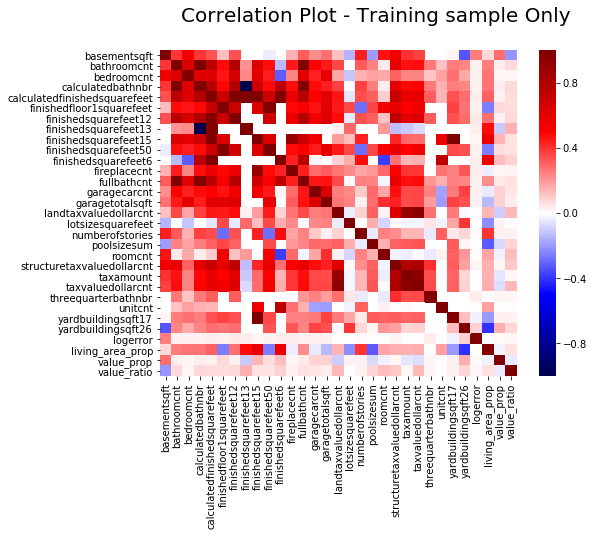

In [9]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Correlation Plot - Training sample Only', fontsize=20)
ax = sns.heatmap(joinedDF[featureList_AllNumerical].corr(),cmap='seismic')

Create a heat map with the numerical features listed above on the entire properties sheet 

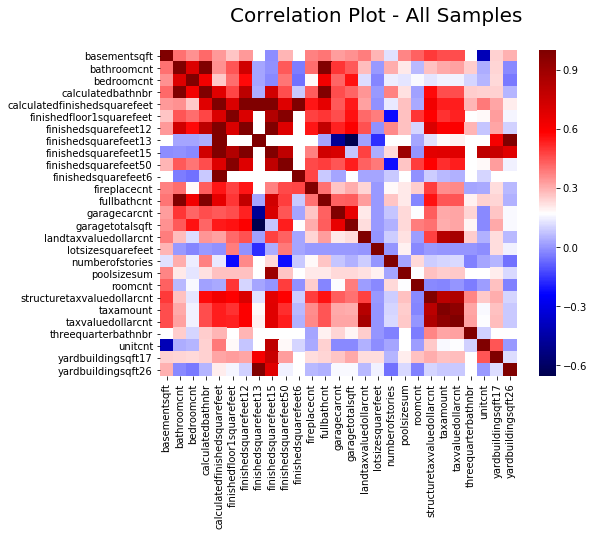

In [10]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Correlation Plot - All Samples', fontsize=20)
ax = sns.heatmap(allFeaturesDF[featureList_AllNumericalNoLogError].corr(),cmap='seismic')

There is no significant change in the corr plot except for few blocks that previously appeared blank, due to enough NA's in the column(it went below the threshold for computation of correlation by Pandas?)

Saving the correlation matrix to csv for later use
joinedDF[featureList_AllNumerical].corr().to_csv("correaltion.csv",sep=',', encoding='utf-8')

Draw a correlation plot to understand absolute relation between two vaiables, i.e. if two variables are at all related negatively or postively

Annotation is turned on to understad the values of correlation

This is plotted on the training data i.e.90k samples only


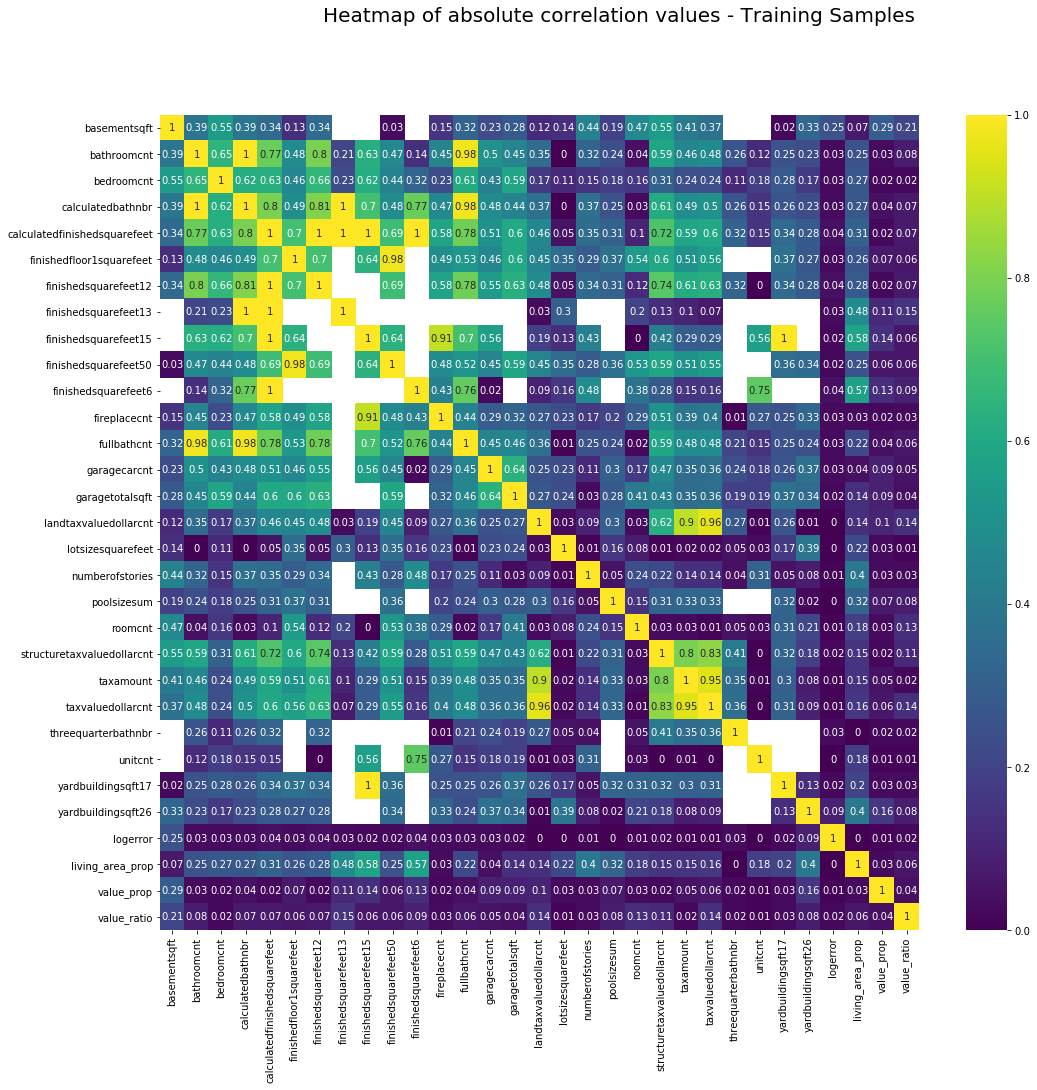

In [11]:
fig = plt.figure(figsize=(17,15))
fig.suptitle('Heatmap of absolute correlation values - Training Samples', fontsize=20)
ax = sns.heatmap(np.around(np.abs(joinedDF[featureList_AllNumerical].corr()),decimals=2),annot=True,cmap='viridis')

Understanding of distribution of number of bedrooms over the training & Entire samples:
This is an attempt to understand how many of the houses of have how many bedrooms in the 90K training population vs Total

The number of bedrooms are capped at 8, with an assumption that a normal residential house(property use ID type 261) wont have bedrooms >8. Further the number of bedrooms with bedroom count >8 are negligible small in the population

Considering the bar plot, it could be observed that it follows a normal distribution trend with mean at 3 bedrooms(which seems quite rasonable !) and reducing on both sides till 8 bedrooms

This trend makes it a good candidate for feature in model since, the training sample is indeed representative of actual sample

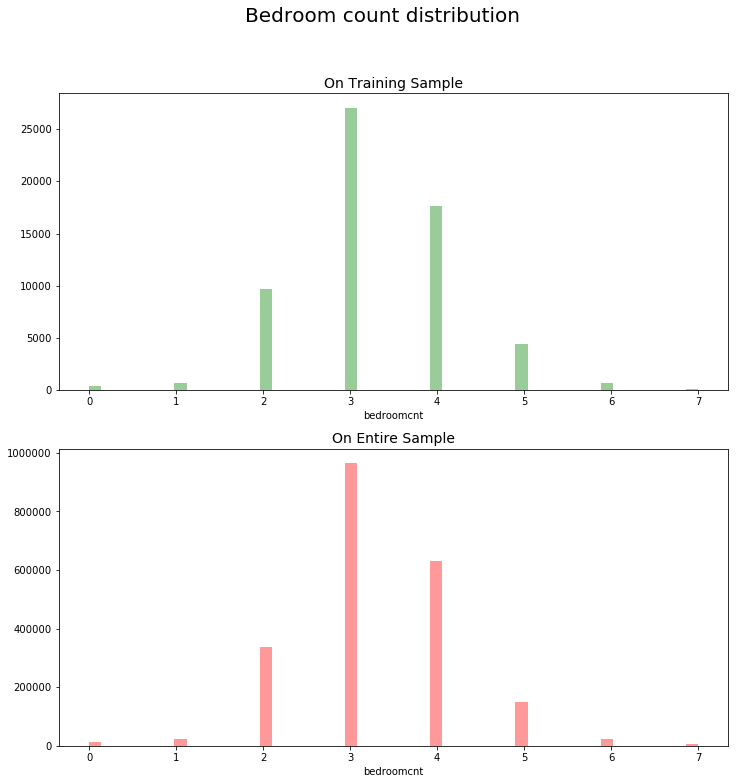

In [12]:
fig,(ax1,ax2) = plt.subplots(2, 1,figsize=(12,12))
fig.suptitle("Bedroom count distribution",fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=5, hspace=None)

bedroomDF=joinedDF.loc[joinedDF['bedroomcnt' ]<8].loc[joinedDF['propertylandusetypeid']==261]
ax1.set_title("On Training Sample",fontsize='14')
sns.distplot(bedroomDF['bedroomcnt'],norm_hist=False,kde=False,color='Green',ax=ax1)

del bedroomDF
ax2.set_title("On Entire Sample",fontsize='14')
bedroomDF=allFeaturesDF.loc[allFeaturesDF['bedroomcnt' ]<8].loc[~allFeaturesDF['bedroomcnt' ].isnull()].loc[allFeaturesDF['propertylandusetypeid']==261]
sns.distplot(bedroomDF['bedroomcnt'],norm_hist=False,kde=False,color='Red',ax=ax2)

Understanding Log Error distribution with Bedroom count and Building Quality Index(Lower the better):
This is a plot of average log error aggregated over each bedroom count i.e. mean log error for 1 bedroom houses,2 bedroom houses and so on

Log Error Vs Bedroom Count(plotted in purple)
It can observed that the log error remains flat through out with minor peaks when the bedroom reaches 7 and drops at 10 and sharp drop at 15. This variation can be attributed to relatively lower number of samples in those section as a result a pretty reasonable log error comes up as a sharp drop/rise due to lower samples(we are determining mean() here)

Log Error Vs Bedroom Count(plotted in Cyan)
It can be observed that there 's a minor rise in log error as the quality of buildings go from good to bad. There is sharp increase in mean log error when the build quality is 8

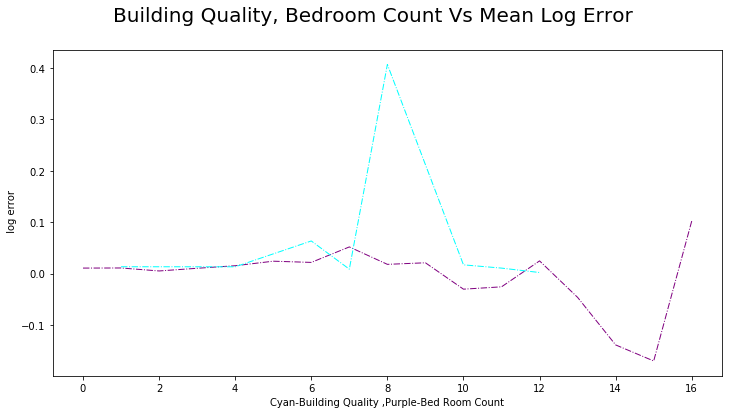

In [13]:
fig,ax1 = plt.subplots(1, 1,figsize=(12,6))
fig.suptitle("Building Quality, Bedroom Count Vs Mean Log Error ",fontsize=20)


BedroomLogerrorDF=pd.Series.to_frame(joinedDF.groupby([joinedDF['bedroomcnt']])['logerror'].mean())
BedroomLogerrorDF=BedroomLogerrorDF.reset_index()
BldgQualityLogerrorDF=pd.Series.to_frame(joinedDF.groupby([joinedDF['buildingqualitytypeid']])['logerror'].mean())
BldgQualityLogerrorDF=BldgQualityLogerrorDF.reset_index()

ax1.set(ylabel=' log error' , xlabel ='Cyan-Building Quality ,Purple-Bed Room Count')
plt.plot(BedroomLogerrorDF['bedroomcnt'],BedroomLogerrorDF['logerror'],color="purple", linewidth=1, linestyle="-.")
plt.plot(BldgQualityLogerrorDF['buildingqualitytypeid'],BldgQualityLogerrorDF['logerror'],
         color="cyan", linewidth=1, linestyle="-.")

Understanding the relation between log of ratio of "taxvaluedollarcnt:The total tax assessed value of the parcel
" and "taxamount:The total property tax assessed for that assessment year"

This is an attempt to uncover any power law relation exisisting among the target variables and the features.
It can be observed that, the graph follows a power law distribution between these two quantities i.e. log error increases/decreases logarithmically with the ratio

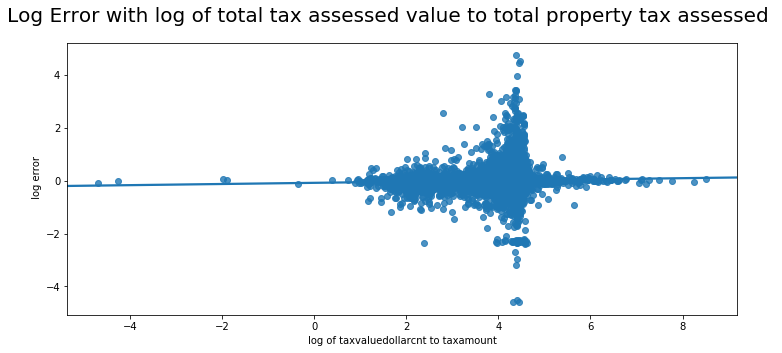

In [14]:
fig,ax1 = plt.subplots(1, 1,figsize=(12,5))
fig.suptitle("Log Error with log of total tax assessed value to total property tax assessed ",fontsize=20)
sns.regplot(np.log(joinedDF['taxvaluedollarcnt']/joinedDF['taxamount']),joinedDF['logerror'],ax=ax1)
ax1.set(ylabel=' log error' , xlabel ='log of taxvaluedollarcnt to taxamount')

Trend Analysis of number of  Number of 3/4 bathrooms in house (shower + sink + toilet) with Year they were built:
Inferance: the trend can be observed after 1960, there were no observations prior to that
the Number of these bathrooms increased over year, possibly they got popular because:
1.as the number of bedroom/rooms in a house increased(assuming they increased over year), 
2.with increase in real estate cost to reduce the bathroom space in a house

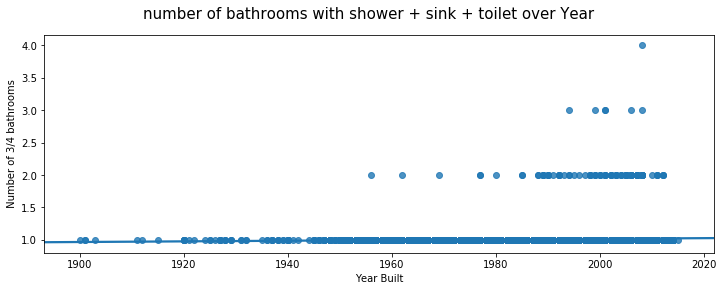

In [15]:
fig,ax1 = plt.subplots(1, 1,figsize=(12,4))
fig.suptitle("number of bathrooms with shower + sink + toilet over Year",fontsize=15)
sns.regplot(joinedDF['yearbuilt'],joinedDF['threequarterbathnbr'])
ax1.set(ylabel=' Number of 3/4 bathrooms' , xlabel ='Year Built')


Understanding the distribution of number of Bathrooms with total finished living area of the home (In Residential property only: comprising 60% population) with Violin plots:
Violin plots attempt to fit the distribution on a normal distribution curve

In this graph we see how the number of bathrooms increases over the square feet of built area:
Houses with built area 1000-2000 sq ft mostly have a 1-2 bathrooms
2000-3000 sq ft with 2-3 bathrooms and houses with sizes greater that 3000 sq ft have 3 or more bathrooms

and this analysis is restricted to number of bathrooms less than 4

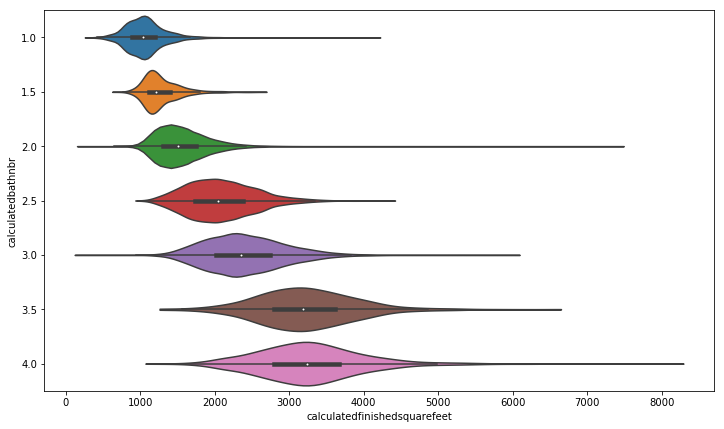

In [16]:
fig = plt.figure(figsize=(12,7))
subsetDF_4bath=joinedDF.loc[joinedDF['propertylandusetypeid']==261].loc[joinedDF['calculatedbathnbr']<=4 ]
sns.violinplot(subsetDF_4bath['calculatedfinishedsquarefeet'],subsetDF_4bath['calculatedbathnbr']
               ,orient='h',cut=0,trim=True,scale="width")

Analysis of average garage size and average house sizes over the year:
    this plot describes what was the average finished area over time(from 1910 onwards) and average garage sizes
    
It can be noted that the house sizes reduced sizeably post War Era, the average finished sq ft also showed a trend of drop during circa 1970 and mid 80's and similarly during 2010 indicating , sizes dropped considerably following a financial collapse or any other historical event impacting the population negatively

weheras the garage sizes showed a downward trend over the year, probably due to increase in real estate cost

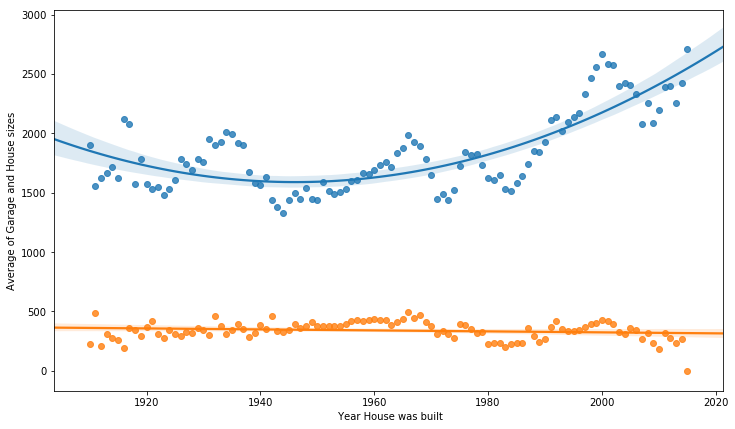

In [17]:
#people are not buying more cars?

meanAreaDF=pd.Series.to_frame(joinedDF.loc[joinedDF['yearbuilt']>=1910].groupby([joinedDF['yearbuilt']])
                    ['calculatedfinishedsquarefeet'].mean())
meanGrgDF=pd.Series.to_frame(joinedDF.loc[joinedDF['yearbuilt']>=1910].groupby([joinedDF['yearbuilt']])
                    ['garagetotalsqft'].mean())

meanAreaDF=meanAreaDF.reset_index()
meanGrgDF=meanGrgDF.reset_index()

# print(meanAreaDF.columns)
meanAreaDF.rename(columns={'calculatedfinishedsquarefeet': 'MeanHouseSize'}, inplace=True)
meanGrgDF.rename(columns={'garagetotalsqft': 'MeanGarageSize'}, inplace=True)

# print(meanAreaDF.loc[6][1])
fig,ax1 = plt.subplots(1, 1,figsize=(12,7))
sns.regplot(meanAreaDF['yearbuilt'],meanAreaDF['MeanHouseSize'],order=2,ax=ax1)
sns.regplot(meanGrgDF['yearbuilt'],meanGrgDF['MeanGarageSize'],ax=ax1)
ax1.set(xlabel=' Year House was built' , ylabel ='Average of Garage and House sizes')

Treatment of missing values in the training samples:
all the columns of type int32 or float32 were imputed with mean() values from their respective columns before proceeding further

In [18]:
#numericalnologerror feature list with synthetic features
featureList_AllNumericalNoLogError=[*featureList_AllNumericalNoLogError,'living_area_prop','value_prop','value_ratio']

In [19]:
print(featureList_AllNumericalNoLogError)

['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'landtaxvaluedollarcnt', 'lotsizesquarefeet', 'numberofstories', 'poolsizesum', 'roomcnt', 'structuretaxvaluedollarcnt', 'taxamount', 'taxvaluedollarcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'living_area_prop', 'value_prop', 'value_ratio']


In [20]:

##pre process , data imputation with mean value

for column,dtype in zip(joinedDF.columns,joinedDF.dtypes):
    if dtype == np.float32 or dtype == np.int32:
        joinedDF[column]=joinedDF[column].fillna(joinedDF[column].mean())     

In [21]:
# create a list string and cateogorical variables

strFeatures=[]
for c,d in zip(joinedDF.columns,joinedDF.dtypes):
    if d == 'object':
        strFeatures.append(c)
    if c.find('code')>0 or c.find('flag')>0 or c.find('block')>0:
        strFeatures.append(c)
        
#create an absolute subset for regression
subsetFtList=['living_area_prop','value_ratio','value_prop','roomcnt','numberofstories','calculatedbathnbr',
             'latitude','longitude','buildingqualitytypeid','finishedsquarefeet12']


X = joinedDF[featureList_AllNumericalNoLogError]
y = joinedDF['logerror']


Run recurssive feature ellimination to determine the mst relevant features in the list of numerical feature

In [22]:
 # use linear regression as the model
lrRFE = lm.LinearRegression()
# rank all features, i.e continue the elimination until the last one
rfe = RFE(lrRFE, n_features_to_select=1,step=0.01)
selector=rfe.fit(X, y)

mpFeatures=pd.DataFrame()
mpFeatures=pd.DataFrame({'ranking':selector.ranking_})
mpFeatures['Feature']=pd.DataFrame(featureList_AllNumericalNoLogError)
mpFeatures.reset_index()

# mapppedFeatureRanks=[(featureList_AllNumericalNoLogError[i],selector.ranking_[i])
#                      for i in range(len(featureList_AllNumericalNoLogError))]

# print(mpFeatures.columns)
# print(mpFeatures)
print(mpFeatures.sort_values('ranking'))

    ranking                       Feature
23        1           threequarterbathnbr
11        2                  fireplacecnt
3         3             calculatedbathnbr
27        4              living_area_prop
1         5                   bathroomcnt
2         6                    bedroomcnt
24        7                       unitcnt
17        8               numberofstories
13        9                  garagecarcnt
12       10                   fullbathcnt
28       11                    value_prop
29       12                   value_ratio
0        13                  basementsqft
7        14          finishedsquarefeet13
19       15                       roomcnt
25       16            yardbuildingsqft17
26       17            yardbuildingsqft26
5        18      finishedfloor1squarefeet
9        19          finishedsquarefeet50
14       20               garagetotalsqft
6        21          finishedsquarefeet12
10       22           finishedsquarefeet6
8        23          finishedsquar

Result of RFE in sorted way:
'threequarterbathnbr'	1
'fireplacecnt'	2
'calculatedbathnbr'	3
'bathroomcnt'	4
'bedroomcnt'	5
'unitcnt'	6
'garagecarcnt'	7
'numberofstories'	8
'fullbathcnt'	9
'roomcnt'	10
'basementsqft'	11
'finishedsquarefeet13'	12
'yardbuildingsqft17'	13
'yardbuildingsqft26'	14
'finishedfloor1squarefeet'	15
'finishedsquarefeet50'	16
'finishedsquarefeet6'	17
'garagetotalsqft'	18
'finishedsquarefeet12'	19
'finishedsquarefeet15'	20
'calculatedfinishedsquarefeet'	21
'poolsizesum'	22
'taxamount'	23
'taxvaluedollarcnt'	24
'landtaxvaluedollarcnt'	25
'structuretaxvaluedollarcnt'	26
'lotsizesquarefeet'	27

Considering top 12 features from numerical bucket

In [23]:
# Split the data into training/testing sets
# Split the data into training/testing sets

#recursive feature ellimination
topFeatures=mpFeatures.loc[:6,'Feature']
lgErrorModel = lm.LinearRegression()

epochs=30

r2_prev=0
r2=0
featureUsed=[]
change=0

lgErrorModelBest=lm.LinearRegression()

#determine the best model among all models on the basis of R2 error from 30 epochs

for ecount in range(epochs):
    Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3, random_state=80)
    lgErrorModel.fit(Xtrain[list(topFeatures)],ytrain)
    ypred = lgErrorModel.predict(Xvalid[list(topFeatures)])
    r2=metrics.r2_score(yvalid, ypred)
    if r2>r2_prev:
        r2_prev=r2
        lgErrorModelBest=lgErrorModel
        change+=1

In [24]:
print(r2_prev)
print(change)
# del Xtrain, Xvalid, ytrain, yvalid, ypred


0.00114151117611
1


Data imputation& new feature creation for the entire population

In [25]:
for column,dtype in zip(allFeaturesDF.columns,allFeaturesDF.dtypes):
    if dtype == np.float32 or dtype == np.int32:
        allFeaturesDF[column]=allFeaturesDF[column].fillna(allFeaturesDF[column].mean())     

In [26]:
##create new variables,Remove variables from the original dframe?
##created at later stage-->after data imputation --->so, plots dont lie
#living area proportions 
allFeaturesDF['living_area_prop'] = allFeaturesDF['calculatedfinishedsquarefeet'] / allFeaturesDF['lotsizesquarefeet']
#tax value ratio
allFeaturesDF['value_ratio'] = allFeaturesDF['taxvaluedollarcnt'] / allFeaturesDF['taxamount']
#tax value proportions
allFeaturesDF['value_prop'] = allFeaturesDF['structuretaxvaluedollarcnt'] / allFeaturesDF['landtaxvaluedollarcnt']

In [27]:
submPred=lgErrorModelBest.predict(allFeaturesDF[list(topFeatures)])
print(type(submPred))

<class 'numpy.ndarray'>


In [28]:
submDF=pd.DataFrame(allFeaturesDF['parcelid'])
submDF.reset_index()
# print(submDF.loc[3,'parcelid'])
submDF["201610"]=submPred
submDF["201611"]=submPred
submDF["201612"]=submPred
submDF["201710"]=submPred
submDF["201711"]=submPred
submDF["201712"]=submPred

print(submDF.loc[3,:])
# print(list(allTargetDF['parcelid']))
print(len(submDF))
submDF.to_csv("submission_lm.csv",  index = False)

parcelid    1.085915e+07
201610      5.929485e-03
201611      5.929485e-03
201612      5.929485e-03
201710      5.929485e-03
201711      5.929485e-03
201712      5.929485e-03
Name: 3, dtype: float64
2985217


In [29]:
##stepping into random forest

Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3, random_state=48)

regr = rfr(max_depth=10, random_state=80,criterion='mse',n_estimators=20)
regr.fit(Xtrain, ytrain)
ytrain=regr.predict(Xtrain)
ypred=regr.predict(Xvalid)

In [30]:
print(metrics.r2_score(yvalid, ypred))

0.00499871200563


Improvement in r2 score from 0.001261 to 0.004998(improvement of 221%)  in employing random forest with max depth of 10 and 20 trees

But the model performed worse than the baseline Lm model on the rest of the unseen data, this might be because of the distribution in the training sample Vs the rest of the data( Maybe there are lot of variables in the rest data which were not considered while model building)

resolution: Need to pick variables from training which are representative of the total sample



In [31]:
submPredRF=regr.predict(allFeaturesDF[featureList_AllNumericalNoLogError])

In [32]:
print(len(submPredRF))

2985217


In [33]:
submDFRF=pd.DataFrame(allFeaturesDF['parcelid'])
submDFRF.reset_index()
# print(submDF.loc[3,'parcelid'])
submDFRF["201610"]=submPredRF
submDFRF["201611"]=submPredRF
submDFRF["201612"]=submPredRF
submDFRF["201710"]=submPredRF
submDFRF["201711"]=submPredRF
submDFRF["201712"]=submPredRF

print(submDFRF.loc[3,:])
print(len(submDFRF))
submDFRF.to_csv("submission_rf_Basline.csv",  index = False)

parcelid    1.085915e+07
201610      1.278158e-02
201611      1.278158e-02
201612      1.278158e-02
201710      1.278158e-02
201711      1.278158e-02
201712      1.278158e-02
Name: 3, dtype: float64
2985217


Addition of categorical variable "BuildingClassTypeID" and few other variables to Random Forest
Although the following three features are not essentially numerical features but can be considered as numerical with assumption:
1.higher latitude /longitude better the house(as a parameter for ranking)
2.lower 'BuildingClassTypeID' better the house

In [34]:
FeatureLikeNumerical=['latitude','longitude','buildingqualitytypeid']
joinedDF['buildingqualitytypeid']=joinedDF['buildingqualitytypeid'].astype(np.uint8)
print(joinedDF[FeatureLikeNumerical].dtypes)

latitude                 float32
longitude                float32
buildingqualitytypeid      uint8
dtype: object


Leabel Encoding:
    Creation of One Hot Encoding(OHE )/Sparse Matrix from the given categorical feature
    

In [35]:
joinedDF['propertylandusetypeid']=joinedDF['propertylandusetypeid'].astype(np.int32)
joinedDF['propertylandusetypeid']=joinedDF['propertylandusetypeid'].astype('category')
catFeatures=['propertylandusetypeid']
propUseDF=pd.get_dummies(joinedDF[catFeatures])
joinedDF=pd.concat([joinedDF, propUseDF], axis=1)
# pd.get_dummies(joinedDF[catFeatures]).columns

In [36]:
catAddedFeatureList=[*FeatureLikeNumerical,*featureList_AllNumericalNoLogError,*propUseDF.columns]
X = joinedDF[catAddedFeatureList]
y = joinedDF['logerror']

In [37]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3, random_state=48)

regr = rfr(max_depth=20, random_state=40,criterion='mse',n_estimators=30,max_features =0.6,min_samples_leaf =100)
regr.fit(Xtrain, ytrain)
# ytrain=regr.predict(Xtrain)
ypred=regr.predict(Xvalid)

In [38]:
print(metrics.r2_score(yvalid, ypred))

0.0124967868017


In [39]:
print(regr.n_features_ )

47


Convert float to categorical in the total sample and perform OHE

In [40]:
del propUseDF
allFeaturesDF['propertylandusetypeid']=allFeaturesDF['propertylandusetypeid'].astype(np.int32)
allFeaturesDF['propertylandusetypeid']=allFeaturesDF['propertylandusetypeid'].astype('category')
propUseDF=pd.get_dummies(allFeaturesDF[catFeatures])
print(pd.concat([allFeaturesDF, propUseDF], axis=1).columns)
allFeaturesDF=pd.concat([allFeaturesDF, propUseDF], axis=1)


Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
   

In [41]:
# print(allFeaturesDF[catAddedFeatureList].columns)

In [42]:
submPredRFCat=regr.predict(allFeaturesDF[catAddedFeatureList])

In [43]:
submPredRFCatDF=pd.DataFrame(allFeaturesDF['parcelid'])
submPredRFCatDF.reset_index()
# print(submDF.loc[3,'parcelid'])
submPredRFCatDF["201610"]=submPredRFCat
submPredRFCatDF["201611"]=submPredRFCat
submPredRFCatDF["201612"]=submPredRFCat
submPredRFCatDF["201710"]=submPredRFCat
submPredRFCatDF["201711"]=submPredRFCat
submPredRFCatDF["201712"]=submPredRFCat

print(submPredRFCatDF.loc[3,:])
print(len(submPredRFCatDF))

parcelid    1.085915e+07
201610      3.932210e-02
201611      3.932210e-02
201612      3.932210e-02
201710      3.932210e-02
201711      3.932210e-02
201712      3.932210e-02
Name: 3, dtype: float64
2985217


In [44]:
submPredRFCatDF.to_csv("submission_rf_cat.csv",  index = False)